Make the MNI group masks to apply to spatial maps:
- Make the pulse reliability mask
- Make group harmonic masks


Functions:

In [1]:
import ants
import nibabel as nib
import numpy as np 

def fMRI_to_MNI(fMRI_img_path, subjectid, interpolator="linear",
                mni_template_path=r"D:\Templates\mni_template.nii"): # "D:\Templates\mni_template.nii"
    """
    Register a volume from subject's native fMRI space to MNI space.

    Parameters
    ----------
    fMRI_img_path : str
        Path to the fMRI-space NIfTI you want to map into MNI (e.g., mean EPI or a map).
    subjectid : str
        Subject ID used to locate transforms.
    interpolator : str
        'linear' or 'BSpline' for continuous maps; 'nearestNeighbor' for labels/masks.
    mni_template_path : str
        MNI template that matches the T1w→MNI transforms you computed (resolution matters!).

    Returns
    -------
    nib.Nifti1Image
        The input volume resampled in MNI space.
    """
    transform_dir = fr"D:\hcp_processed\{subjectid}\transforms"
    # forward transforms (do NOT invert for fMRI→MNI)
    affine_fmri_to_t1 = fr"{transform_dir}\fMRI_to_T1w_0GenericAffine.mat"
    affine_t1_to_mni  = fr"{transform_dir}\T1w_to_MNI_0GenericAffine.mat"
    warp_t1_to_mni    = fr"{transform_dir}\T1w_to_MNI_1Warp.nii.gz"  # forward field

    fixed_mni = ants.image_read(mni_template_path)     # target (MNI) space
    moving_epi = ants.image_read(fMRI_img_path)        # source (native fMRI) space

    transformed = ants.apply_transforms(
        fixed=fixed_mni,
        moving=moving_epi,
        # Order here is important: last in list is applied first.
        transformlist=[warp_t1_to_mni, affine_t1_to_mni, affine_fmri_to_t1],
        whichtoinvert=[False, False, False],
        interpolator=interpolator
    )

    # Return as nibabel NIfTI using the MNI header/affine
    mni_ref = nib.load(mni_template_path)
    out_img = nib.Nifti1Image(transformed.numpy(), affine=mni_ref.affine, header=mni_ref.header)
    return out_img


In [2]:
def fisher_transform(r):
    """Applies Fisher z-transformation to correlation values (r)."""
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_transform(z):
    """Converts a Fisher z-score back to correlation values (r)."""
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


End of functions

In [3]:
# get subjects from subjects.txt:
# Path to your subject list file
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

# Read all IDs into a Python list
with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]

print("Loaded", len(subjects), "subjects:")

# subjects = subjects[:157]
print(subjects) 


Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828', '109123', '110411', '111716', '113619', '113821', '113922', '114419', '115320', '116524', '118528', '118932', '120212', '121618', '123420', '124220', '124826', '127630', '128127', '129533', '130013', '132118', '133827', '136833', '137027', '137128', '137936', '138231', '140117', '140824', '142424', '142828', '143325', '144832', '145531', '146331', '146432', '148941', '150423', '150726', '151627', '153833', '154734', '154936', '155635', '156637', '158035', '159138', '161630', '161731', '162733', '163331', '164131', '165032', '167743', '168341', '169343', '169444', '170934', '172130', '172938', '173536', '175035', '177645', '178950', '179346', '180129', '180836', '180937', '181232', '183034', '185139', '186141', '187143', '187547', '188347', '189349', '191033', '191437', '191841', '192540', '192843', '194140', '194847', '195849', '197348', '198855', '199150', '199251'

In [4]:
# parameters tell us which pulse reliability maps to load 
nbins = 40 # number of bins for the aligned cardiac waveform 
B = 5 # number of permutation 
TR = 0.720 # TR
high_pass = 0.0042


In [5]:
import pandas as pd
# Load subjects that were excluded earlier (from regression/outlier filtering/etc.)
excluded_df = pd.read_csv(r"D:\hcp_processed\excluded_subjects3.csv")
excluded_subjects = set(excluded_df["Subject"].astype(str).tolist())
print(f"✅ Loaded {len(excluded_subjects)} excluded subjects")


✅ Loaded 31 excluded subjects


In [6]:
# average subjects together:
subject_z_maps = []
count = 0
Subjects_skipped = []

for subjectid in subjects:
    file_path = fr'D:\hcp_processed\{subjectid}\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}.nii.gz'
    print(f"subject {subjectid}")
    # rel_img = nib.load(file_path)

    #### --- SKIPPING SUBJECTS --- ####################
    ### skip subjects with very low number of reliable voxels (can try < 500 for > 0.4 or 0.3 r^2)
    # # load in niftiat file_path, get data, threshold at 0.3, np.sum it 
    # num_reliable_voxels = np.sum(nib.load(file_path).get_fdata() > 0.3)
    # print(f"{num_reliable_voxels} reliable voxels")
    # if num_reliable_voxels < 500:
    #     Subjects_skipped.append(subjectid)   # save which subjects were skipped due to low reliability:
    #     count = count + 1
    #     continue
    if subjectid in excluded_subjects:
        print(f"⏩ Skipping {subjectid} (in excluded_subjects list)")
        Subjects_skipped.append(subjectid)
        continue

    ### - end of skipping subjects ###############3

    pulse_r2_nifti = fMRI_to_MNI(file_path, subjectid, interpolator="linear")

    r2_data = pulse_r2_nifti.get_fdata()  # Load as numpy array

    r2_data[r2_data < 0] = np.nan  # Ignore negative R² values by setting them to NaN
    r_data = np.sqrt(r2_data) # Convert R² to r (assuming positive correlations)

    z_data = np.where(~np.isnan(r_data), fisher_transform(r_data), np.nan) # Convert r to Fisher z-space (ignoring NaNs)
    subject_z_maps.append(z_data)

# Stack across time and compute mean in Fisher z-space (ignoring NaNs)
z_maps_stack = np.stack(subject_z_maps, axis=-1)
mean_z_map = np.nanmean(z_maps_stack, axis=-1)

mean_r_map = inverse_fisher_transform(mean_z_map) # Convert back to r-space
mean_r2_map = mean_r_map ** 2 # Convert back to R²
mean_r2_nifti = nib.Nifti1Image(mean_r2_map, affine=pulse_r2_nifti.affine, header=pulse_r2_nifti.header)

print(f"{count} subjects were removed due to low pulse reliability")

# # convert to MNI space for the subject
# output_nifti_path = fr'{path_pulseR2}\MNI_pulseR2.nii.gz'
# pulseR2_mni_paths[subject] = fmri_to_MNI(mean_r2_nifti, subject, output_nifti_path) # path for r2 maps for each subject in mni space


subject 100307
subject 101309
subject 102008
subject 102311
subject 103111
subject 103414
⏩ Skipping 103414 (in excluded_subjects list)
subject 103818
subject 105014
subject 107422
⏩ Skipping 107422 (in excluded_subjects list)
subject 108828
subject 109123
subject 110411
subject 111716
⏩ Skipping 111716 (in excluded_subjects list)
subject 113619
subject 113821
subject 113922
subject 114419
subject 115320
⏩ Skipping 115320 (in excluded_subjects list)
subject 116524
subject 118528
subject 118932
subject 120212
subject 121618
subject 123420
subject 124220
⏩ Skipping 124220 (in excluded_subjects list)
subject 124826
subject 127630
subject 128127
subject 129533
⏩ Skipping 129533 (in excluded_subjects list)
subject 130013
⏩ Skipping 130013 (in excluded_subjects list)
subject 132118
subject 133827
subject 136833
subject 137027
subject 137128
subject 137936
subject 138231
subject 140117
subject 140824
⏩ Skipping 140824 (in excluded_subjects list)
subject 142424
⏩ Skipping 142424 (in excluded_s

In [7]:
# save the group R^2 map, 
import os
folder_path = r"D:\hcp_processed\GroupResults"
os.makedirs(folder_path, exist_ok=True)
out_path = fr'D:\hcp_processed\GroupResults\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}_{len(subjects)}subject.nii.gz'
nib.save(mean_r2_nifti, out_path)


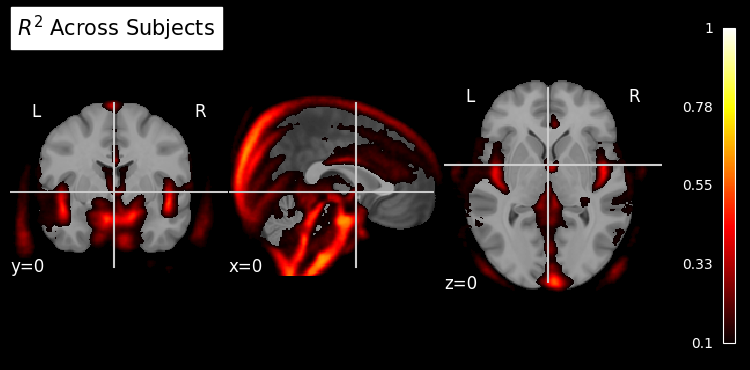

In [8]:
# plot group r2 image:
from nilearn import plotting
from nilearn.datasets import load_mni152_template
mni_template = load_mni152_template()

threshold = 0.1
vmax = 1
cut_coords = (0,0,0)
plotting.plot_stat_map(
    mean_r2_nifti,
    bg_img = mni_template,
    title=r"$R^2$ Across Subjects",
    cut_coords=cut_coords,
    colorbar=True,
    draw_cross=True,
    cmap = 'hot',
    vmin=threshold, vmax=vmax,
    # vmin=0, vmax=1,
    alpha = 1, #0.5,
    threshold = threshold #0.0007
    )
plotting.show()



Group mask for H1/DC:

In [9]:
import numpy as np
import nibabel as nib
import os

running_sum = None
running_count = None

# subjects = subjects[:2] # for testing 

for subjectid in subjects:
    # if subjectid in Subjects_skipped:
    #     continue
    #### --- SKIPPING SUBJECTS --- ####################
    if subjectid in excluded_subjects:
        print(f"⏩ Skipping {subjectid} (in excluded_subjects list)")
        Subjects_skipped.append(subjectid)
        continue
    ### - end of skipping subjects ###############3

    # --- Load and compute H1DC for individual subject ---
    # A1_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmonicDC1.nii.gz") # density compensation
    nbins_phase = 30
    A1_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin1_nbins{nbins_phase}.nii.gz") # MoreharmBin.ipynb, binning, Normalized to DC before motion regression and cardiac realignment. 

    A1 = A1_nifti.get_fdata()

    H1DC = A1   # creates 3D array

    # Save subject-level nifti (optional)
    h1dc_folder = fr"D:\hcp_processed\{subjectid}\Maps"
    os.makedirs(h1dc_folder, exist_ok=True)
    H1DC_nifti_path = fr"{h1dc_folder}\H1DC.nii.gz"
    nib.save(nib.Nifti1Image(H1DC, A1_nifti.affine, A1_nifti.header), H1DC_nifti_path)

    # Transform to MNI
    H1DC_nifti_mni = fMRI_to_MNI(H1DC_nifti_path, subjectid, interpolator="linear")
    H1DC_data = H1DC_nifti_mni.get_fdata()

    # --- Incremental mean (NaN aware, no stacking) ---
    if running_sum is None:
        running_sum = np.zeros_like(H1DC_data, dtype=np.float64)
        running_count = np.zeros_like(H1DC_data, dtype=np.int32)

    mask = ~np.isnan(H1DC_data)
    running_sum[mask] += H1DC_data[mask]
    running_count[mask] += 1

# Final mean
mean_h1dc_map = running_sum / running_count
mean_h1dc_nifti = nib.Nifti1Image(mean_h1dc_map, affine=H1DC_nifti_mni.affine)


⏩ Skipping 103414 (in excluded_subjects list)
⏩ Skipping 107422 (in excluded_subjects list)
⏩ Skipping 111716 (in excluded_subjects list)
⏩ Skipping 115320 (in excluded_subjects list)
⏩ Skipping 124220 (in excluded_subjects list)
⏩ Skipping 129533 (in excluded_subjects list)
⏩ Skipping 130013 (in excluded_subjects list)
⏩ Skipping 140824 (in excluded_subjects list)
⏩ Skipping 142424 (in excluded_subjects list)
⏩ Skipping 153833 (in excluded_subjects list)
⏩ Skipping 158035 (in excluded_subjects list)
⏩ Skipping 159138 (in excluded_subjects list)
⏩ Skipping 163331 (in excluded_subjects list)
⏩ Skipping 180937 (in excluded_subjects list)
⏩ Skipping 191437 (in excluded_subjects list)
⏩ Skipping 192843 (in excluded_subjects list)
⏩ Skipping 205119 (in excluded_subjects list)
⏩ Skipping 316633 (in excluded_subjects list)
⏩ Skipping 366446 (in excluded_subjects list)
⏩ Skipping 414229 (in excluded_subjects list)
⏩ Skipping 433839 (in excluded_subjects list)
⏩ Skipping 436239 (in excluded_sub

mean_h1dc_map max: 0.05228021234177264
mean_h1dc_map min: 0.0


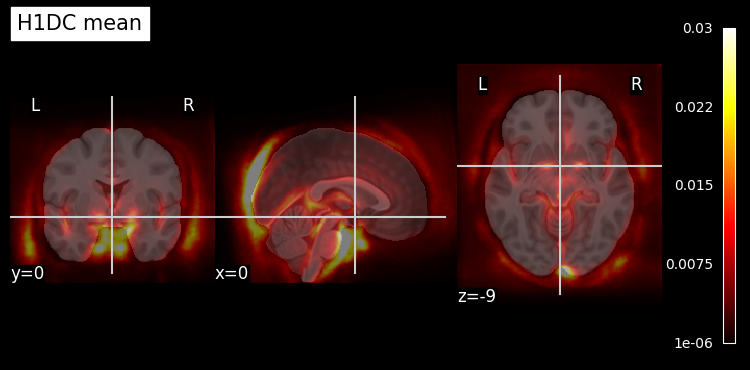

In [10]:
print(f"mean_h1dc_map max: {np.max(mean_h1dc_map)}")
print(f"mean_h1dc_map min: {np.min(mean_h1dc_map)}")

threshold = 0.1 
vmax = 0.03 # 5e-5
cut_coords = (0,0,-9)
plotting.plot_stat_map(
    mean_h1dc_nifti,
    bg_img = mni_template,
    title=f"H1DC mean",
    cut_coords=cut_coords,
    colorbar=True,
    draw_cross=True,
    cmap = 'hot',
    vmin=0, vmax=vmax,
    alpha = .5, #0.5,
    # threshold = threshold #0.0007
    )
plotting.show()


In [11]:
# save the group H1DC map, 
import os
folder_path = r"D:\hcp_processed\GroupResults"
os.makedirs(folder_path, exist_ok=True)
out_path = fr'D:\hcp_processed\GroupResults\H1DC_MNI{len(subjects)}subject.nii.gz'
nib.save(mean_h1dc_nifti, out_path)


Turn H1DC and pulse reliability into MIPs:

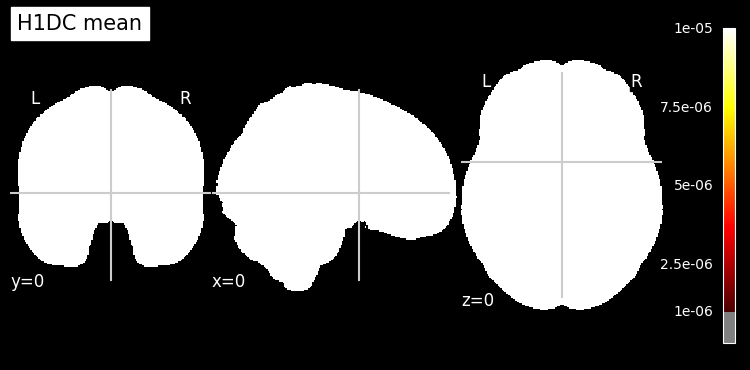

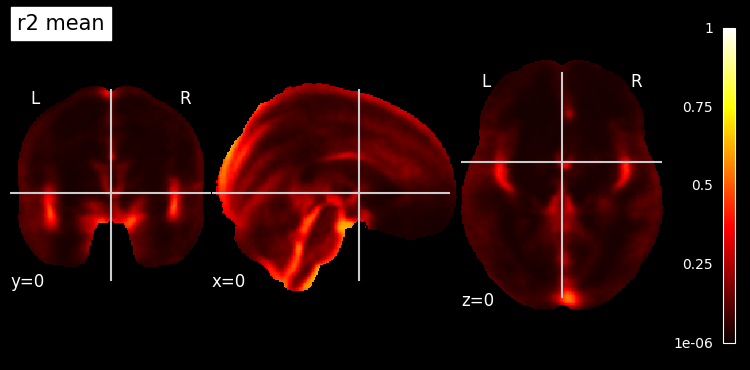

In [12]:
# need to mask out brain? But that could mask out the sagittal sinus too:

from nilearn import datasets
icbm = datasets.fetch_icbm152_2009()
# Access CSF map
csf_img = icbm['csf']
csf_data = nib.load(csf_img).get_fdata() # Optional: Threshold to make binary mask
gm_img = icbm['gm']
gm_data = nib.load(gm_img).get_fdata() # Optional: Threshold to make binary mask
wm_img = icbm['wm']
wm_data = nib.load(wm_img).get_fdata() # Optional: Threshold to make binary mask
thresh_nb = 0.01
brain_mask = ((csf_data > thresh_nb) | (gm_data > thresh_nb) | (wm_data > thresh_nb))

mean_h1dc_map_brain = brain_mask*mean_h1dc_map
mean_r2_map_brain = brain_mask*mean_r2_map
mean_h1dc_brain_nifti = nib.Nifti1Image(mean_h1dc_map_brain, affine=H1DC_nifti_mni.affine, header=H1DC_nifti_mni.header)
r2_brain_nifti = nib.Nifti1Image(mean_r2_map_brain, affine=H1DC_nifti_mni.affine, header=H1DC_nifti_mni.header)


threshold = 0.1 
vmax = 1e-5 # 5e-5
cut_coords = (0,0,0)
plotting.plot_stat_map(
    mean_h1dc_brain_nifti,
    bg_img = mni_template,
    title=f"H1DC mean",
    cut_coords=cut_coords,
    colorbar=True,
    draw_cross=True,
    cmap = 'hot',
    vmin=0, vmax=vmax,
    alpha = 1, #0.5,
    # threshold = threshold #0.0007
    )
plotting.show()

threshold = 0.1 
vmax = 1 # 5e-5
cut_coords = (0,0,0)
plotting.plot_stat_map(
    r2_brain_nifti,
    bg_img = mni_template,
    title=f"r2 mean",
    cut_coords=cut_coords,
    colorbar=True,
    draw_cross=True,
    cmap = 'hot',
    vmin=0, vmax=vmax,
    alpha = 1, #0.5,
    # threshold = threshold #0.0007
    )
plotting.show()



In [13]:
# get MIPs of these:
print(f"mean_h1dc_map_brain.shape {mean_h1dc_map_brain.shape}")
print(f"mean_r2_map_brain.shape {mean_r2_map_brain.shape}")


mean_h1dc_map_brain.shape (197, 233, 189)
mean_r2_map_brain.shape (197, 233, 189)


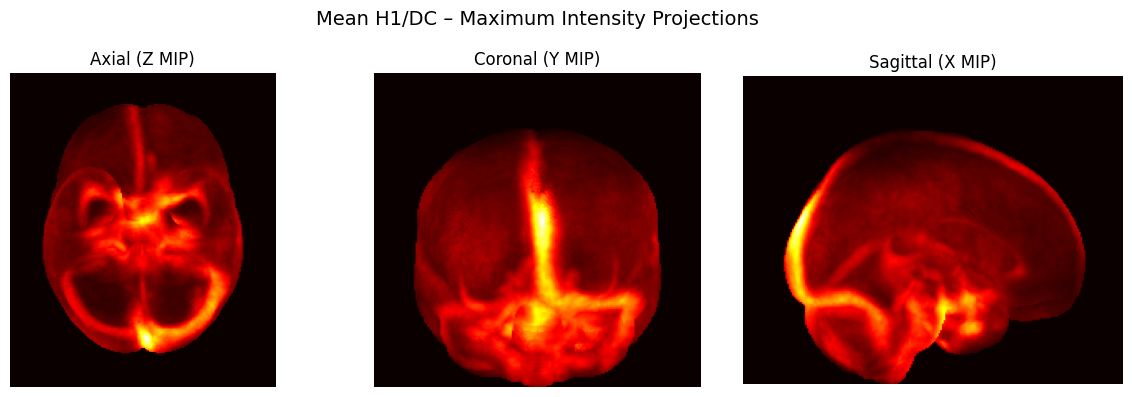

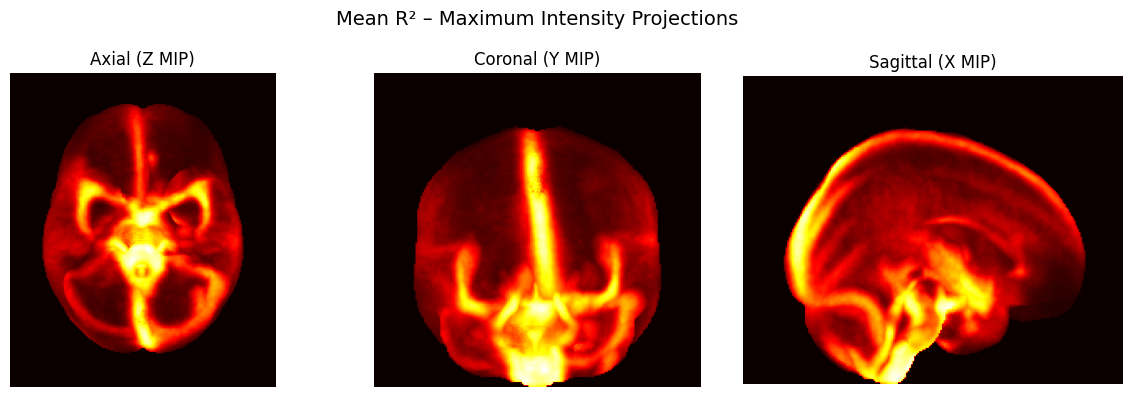

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have these arrays:
# mean_h1dc_map_brain = mean_h1dc_nifti.get_fdata()
# mean_r2_map_brain = mean_r2_nifti.get_fdata()

def plot_mips(volume, title_prefix):
    """Compute and plot MIPs along the three anatomical axes."""
    # Compute maximum intensity projections
    mip_axial = np.max(volume, axis=2)     # collapse over z
    mip_coronal = np.max(volume, axis=1)   # collapse over y
    mip_sagittal = np.max(volume, axis=0)  # collapse over x

    # Plot all three projections
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"{title_prefix} – Maximum Intensity Projections", fontsize=14)

    axes[0].imshow(np.rot90(mip_axial), cmap='hot')
    axes[0].set_title("Axial (Z MIP)")
    axes[1].imshow(np.rot90(mip_coronal), cmap='hot')
    axes[1].set_title("Coronal (Y MIP)")
    axes[2].imshow(np.rot90(mip_sagittal), cmap='hot')
    axes[2].set_title("Sagittal (X MIP)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# --- Plot MIPs for both maps ---
plot_mips(mean_h1dc_map_brain, "Mean H1/DC")
plot_mips(mean_r2_map_brain, "Mean R²")


Can we see pulsatile dampening?

In [15]:
print(f"mean_h1dc_map_brain.shape {mean_h1dc_map_brain.shape}")
# look at voxel in Basilar, and look at voxel in a smaller artery:

mean_h1dc_map_brain.shape (197, 233, 189)


cyan     → Basilar: (0, -12, -25)
magenta  → ICA (right): (18, 0, -15)
yellow   → ACA (midline frontal): (0, 20, -10)


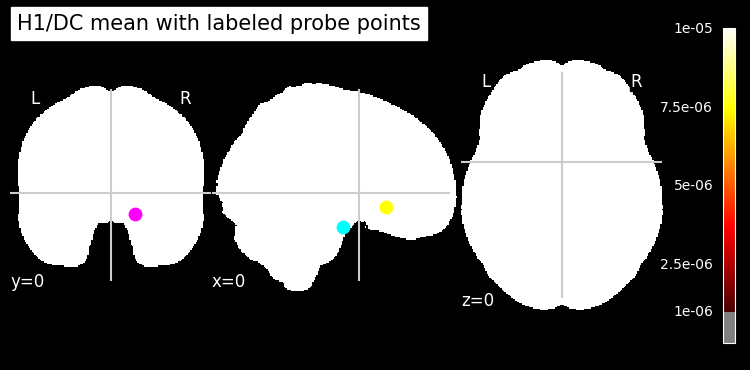

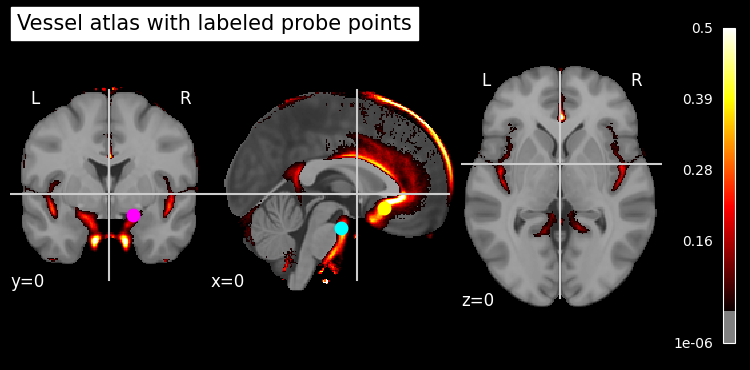

Local mean H1/DC (≈3 mm neighborhood):
Basilar                      @ (0, -12, -25): 2.957e-02
ICA (right)                  @ (18, 0, -15): 1.777e-02
ACA (midline frontal)        @ (0, 20, -10): 4.312e-03


In [16]:
import numpy as np
import nibabel as nib
from nilearn import plotting

# --- Inputs you already have ---
# mean_h1dc_brain_nifti : NIfTI with your H1/DC map (same space as mni_template)
# mni_template          : background NIfTI (brain in MNI)

img = mean_h1dc_brain_nifti
data = img.get_fdata()
aff  = img.affine
zooms = img.header.get_zooms()[:3]  # voxel sizes (mm)

# ---- Helper: sample a small cube around an MNI coordinate ----
def mni_to_ijk(xyz_mni, affine):
    ijk = np.linalg.inv(affine) @ np.array([*xyz_mni, 1.0])
    return tuple(np.round(ijk[:3]).astype(int))

def sample_local_mean(img_data, xyz_mni, affine, radius_mm=3.0): # radius_mm=3.0
    i, j, k = mni_to_ijk(xyz_mni, affine)
    rx = int(np.ceil(radius_mm / zooms[0]))
    ry = int(np.ceil(radius_mm / zooms[1]))
    rz = int(np.ceil(radius_mm / zooms[2]))
    # bounds-safe slice
    sx = slice(max(i-rx,0), min(i+rx+1, img_data.shape[0]))
    sy = slice(max(j-ry,0), min(j+ry+1, img_data.shape[1]))
    sz = slice(max(k-rz,0), min(k+rz+1, img_data.shape[2]))
    cube = img_data[sx, sy, sz]
    return float(np.nanmean(cube))

from nilearn import plotting

# keep your previous ROI dictionary
roi_points = {
    "Basilar": (0, -12, -25),
    # "PCA (left)": (-20, -60, -10),
    # "MCA (right)": (45, 0, -10),
    "ICA (right)": (18, 0, -15),
    "ACA (midline frontal)": (0, 20, -10),
}

# assign a distinct color per ROI
roi_colors = {
    "Basilar": "cyan",
    # "PCA (left)": "lime",
    # "MCA (right)": "magenta",
    "ICA (right)": "magenta",
    "ACA (midline frontal)": "yellow",
}

display = plotting.plot_stat_map(
    mean_h1dc_brain_nifti,
    bg_img=mni_template,
    title="H1/DC mean with labeled probe points",
    cut_coords=(0, 0, 0),
    cmap="hot", vmin=0, vmax=1e-5,
    colorbar=True, draw_cross=True,
)
# add points with individual colors
for name, coord in roi_points.items():
    display.add_markers([coord],
                        marker_color=roi_colors[name],
                        marker_size=80)
    print(f"{roi_colors[name]:8s} → {name}: {coord}")
plotting.show()


display = plotting.plot_stat_map(
    r"D:\Templates\vs_data_resampled.nii.gz",
    bg_img=mni_template,
    title="Vessel atlas with labeled probe points",
    cut_coords=(0, 0, 0),
    cmap="hot", 
    vmin=0.05, vmax=0.5,
    colorbar=True, draw_cross=True,
)
# add points with individual colors
for name, coord in roi_points.items():
    display.add_markers([coord],
                        marker_color=roi_colors[name],
                        marker_size=80)
    # print(f"{roi_colors[name]:8s} → {name}: {coord}")
plotting.show()

print("Local mean H1/DC (≈3 mm neighborhood):")
for name, xyz in roi_points.items():
    val = sample_local_mean(data, xyz, aff, radius_mm=3.0) # what radius_mm to use?
    print(f"{name:28s} @ {xyz}: {val:.3e}")




In [17]:
# re-do the above, converting from MNI -> voxel coordinates does not work. 

Local mean H1/DC (????? voxel neighborhood):
Basilar                   @ (98, 122, 48): 3.456e-02: cyan
ICA (right)               @ (118, 122, 95): 3.016e-03: magenta
ACA (midline frontal)     @ (98, 155, 65): 3.890e-03: yellow


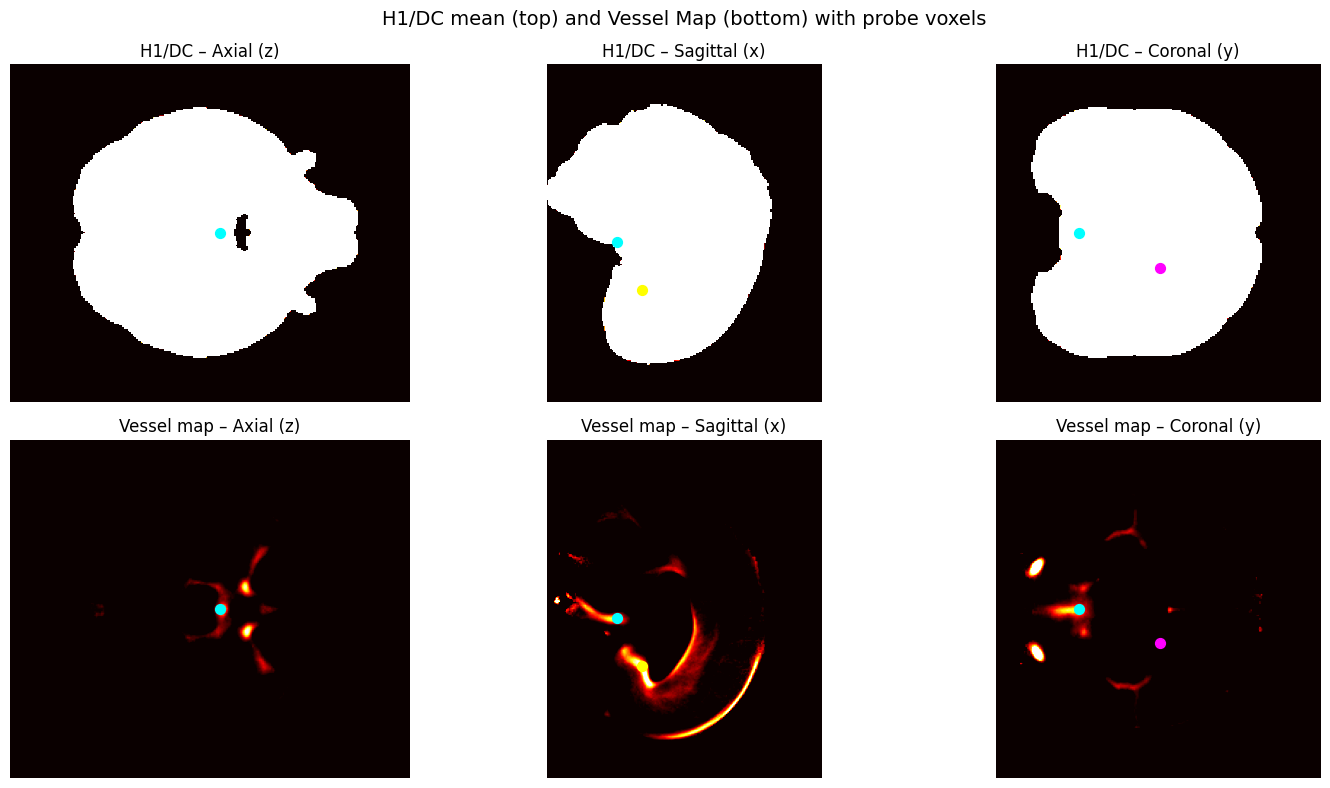

In [18]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# --- Load your NIfTIs ---
h1dc_img = mean_h1dc_brain_nifti
vessel_img = nib.load(r"D:\Templates\vs_data_resampled.nii.gz")

h1dc_data = h1dc_img.get_fdata()
vessel_data = vessel_img.get_fdata()

# --- Define your voxel coordinates ---
roi_voxels = {
    "Basilar": (98, 122, 48), # ( , y-direction, z-direction)
    "ICA (right)": (118, 122, 95),
    "ACA (midline frontal)": (98, 155, 65),
}

roi_colors = {
    "Basilar": "cyan",
    "ICA (right)": "magenta",
    "ACA (midline frontal)": "yellow",
}

# --- Helper: sample local mean around voxel ---
def sample_local_mean_voxel(data, ijk, radius_vox=1):
    i, j, k = ijk
    sx = slice(max(i - radius_vox, 0), min(i + radius_vox + 1, data.shape[0]))
    sy = slice(max(j - radius_vox, 0), min(j + radius_vox + 1, data.shape[1]))
    sz = slice(max(k - radius_vox, 0), min(k + radius_vox + 1, data.shape[2]))
    cube = data[sx, sy, sz]
    return float(np.nanmean(cube))

# --- Print local mean values ---
print("Local mean H1/DC (????? voxel neighborhood):")
for name, ijk in roi_voxels.items():
    val = sample_local_mean_voxel(h1dc_data, ijk, radius_vox=1)
    print(f"{name:25s} @ {ijk}: {val:.3e}: {roi_colors[name]}")

# --- Select slices roughly centered on Basilar voxel ---
x0, y0, z0 = roi_voxels["Basilar"]

# --- Plot both maps in voxel space ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
titles = ['Axial (z)', 'Sagittal (x)', 'Coronal (y)']

# Slice indices
slices = {
    'axial': z0,
    'sagittal': x0,
    'coronal': y0
}

for col, (name, slc) in enumerate(slices.items()):
    # --- Top row: H1/DC ---
    ax = axes[0, col]
    if slc >= h1dc_data.shape[2]: continue
    if name == 'axial':
        ax.imshow((h1dc_data[:, :, slc]), cmap='hot', vmin=0, vmax=1e-5)
    elif name == 'sagittal':
        ax.imshow((h1dc_data[slc, :, :]), cmap='hot', vmin=0, vmax=1e-5)
    elif name == 'coronal':
        ax.imshow((h1dc_data[:, slc, :]), cmap='hot', vmin=0, vmax=1e-5)
    ax.set_title(f"H1/DC – {titles[col]}")
    ax.axis('off')

    # overlay probe voxels
    # for rname, (x, y, z) in roi_voxels.items():
    #     if name == 'axial' and z == slc:
    #         ax.scatter(y, x, c=roi_colors[rname], s=50, label=rname)
    #     elif name == 'sagittal' and x == slc:
    #         ax.scatter(z, y, c=roi_colors[rname], s=50, label=rname)
    #     elif name == 'coronal' and y == slc:
    #         ax.scatter(z, x, c=roi_colors[rname], s=50, label=rname)
    for rname, (x, y, z) in roi_voxels.items():
        if name == 'axial' and z == slc:
            ax.scatter(y, x, c=roi_colors[rname], s=50)
        elif name == 'sagittal' and x == slc:
            ax.scatter(z, y, c=roi_colors[rname], s=50)
        elif name == 'coronal' and y == slc:
            ax.scatter(z, x, c=roi_colors[rname], s=50)

    # --- Bottom row: vessel map ---
    ax = axes[1, col]
    if name == 'axial':
        ax.imshow((vessel_data[:, :, slc]), cmap='hot', vmin=0.05, vmax=0.5)
    elif name == 'sagittal':
        ax.imshow((vessel_data[slc, :, :]), cmap='hot', vmin=0.05, vmax=0.5)
    elif name == 'coronal':
        ax.imshow((vessel_data[:, slc, :]), cmap='hot', vmin=0.05, vmax=0.5)
    ax.set_title(f"Vessel map – {titles[col]}")
    ax.axis('off')

    # overlay same voxel markers
    for rname, (x, y, z) in roi_voxels.items():
        if name == 'axial' and z == slc:
            ax.scatter(y, x, c=roi_colors[rname], s=50)
            # ax.scatter(x, y, c=roi_colors[rname], s=50)
        elif name == 'sagittal' and x == slc:
            ax.scatter(z, y, c=roi_colors[rname], s=50)
            # ax.scatter(y, z, c=roi_colors[rname], s=50)
        elif name == 'coronal' and y == slc:
            ax.scatter(z, x, c=roi_colors[rname], s=50)
            # ax.scatter(x, z, c=roi_colors[rname], s=50)

fig.suptitle("H1/DC mean (top) and Vessel Map (bottom) with probe voxels", fontsize=14)
plt.tight_layout()
plt.show()


Local mean H1/DC (????? voxel neighborhood):
Basilar1                  @ (98, 111, 23): 1.481e-02: blue
Basilar2                  @ (98, 115, 28): 1.908e-02: blue
Basilar3                  @ (98, 121, 39): 3.292e-02: blue
Basilar4                  @ (98, 122, 48): 3.456e-02: blue
ACA                       @ (98, 155, 65): 3.890e-03: cyan


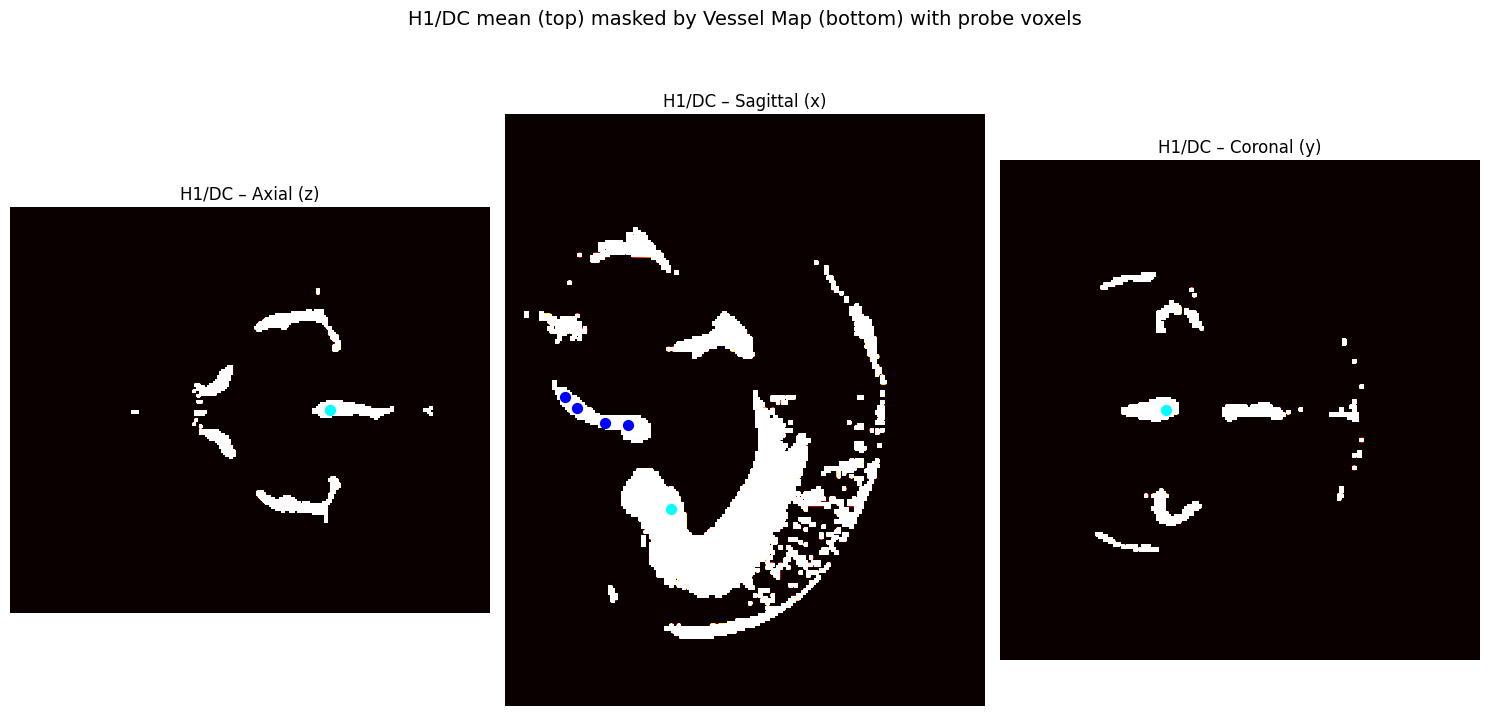

In [19]:
# mask in only the vessels, then see if we can track the dampening:
fMRI_vessel_mask = nib.load(r"D:\Templates\vs_data_resampled.nii.gz").get_fdata() > 0.05
data_vessel = data * fMRI_vessel_mask

h1dc_data = data_vessel

# --- Define your voxel coordinates ---
roi_voxels = {
    "Basilar1": (98, 111, 23), # ( , y-direction, z-direction)
    "Basilar2": (98, 115, 28), # ( , y-direction, z-direction)
    "Basilar3": (98, 121, 39), # ( , y-direction, z-direction)
    "Basilar4": (98, 122, 48), # ( , y-direction, z-direction)
    "ACA": (98, 155, 65),
    # "ICA (right)": (118, 122, 95),
    # "ACA (midline frontal)": (98, 155, 65),
}

roi_colors = {
    "Basilar1": "blue",
    "Basilar2": "blue",
    "Basilar3": "blue",
    "Basilar4": "blue",
    "ACA": "cyan",
    # "ICA (right)": "magenta",
    # "ACA (midline frontal)": "yellow",
}

# --- Print local mean values ---
print("Local mean H1/DC (????? voxel neighborhood):")
for name, ijk in roi_voxels.items():
    val = sample_local_mean_voxel(h1dc_data, ijk, radius_vox=1)
    print(f"{name:25s} @ {ijk}: {val:.3e}: {roi_colors[name]}")

############## --- Select slices roughly centered on Basilar voxel --- SELECT WHICH SLICES TO VIEW FOR THE ROI
# x0, y0, z0 = roi_voxels["Basilar4"]
x0, y0, z0 = roi_voxels["ACA"]

#############

fig, axes = plt.subplots(1, 3, figsize=(15, 8))
titles = ['Axial (z)', 'Sagittal (x)', 'Coronal (y)']

slices = {
    'axial': z0,
    'sagittal': x0,
    'coronal': y0
}

for col, (name, slc) in enumerate(slices.items()):
    # --- H1/DC with vessel mask ---
    ax = axes[col]

    if slc >= h1dc_data.shape[2]: continue
    if name == 'axial':
        ax.imshow((h1dc_data[:, :, slc]), cmap='hot', vmin=0, vmax=1e-5)
    elif name == 'sagittal':
        ax.imshow((h1dc_data[slc, :, :]), cmap='hot', vmin=0, vmax=1e-5)
    elif name == 'coronal':
        ax.imshow((h1dc_data[:, slc, :]), cmap='hot', vmin=0, vmax=1e-5)
    ax.set_title(f"H1/DC – {titles[col]}")
    ax.axis('off')

    # overlay probe voxels
    for rname, (x, y, z) in roi_voxels.items():
        if name == 'axial' and z == slc:
            ax.scatter(y, x, c=roi_colors[rname], s=50, label=rname)
        elif name == 'sagittal' and x == slc:
            ax.scatter(z, y, c=roi_colors[rname], s=50, label=rname)
        elif name == 'coronal' and y == slc:
            ax.scatter(z, x, c=roi_colors[rname], s=50, label=rname)

fig.suptitle("H1/DC mean (top) masked by Vessel Map (bottom) with probe voxels", fontsize=14)
plt.tight_layout()
plt.show()
